In [1]:
#!pip install scikit-learn
#!pip install tensorflow
#!pip install tensorflow-gpu


In [2]:
import numpy as np

In [5]:
import random
import os
import numpy as np

# crossValidationDataPaths=['NORMALIZED/NumericalData/ML/Training/RightHand','NORMALIZED/NumericalData/ML/Training/LeftHand']
# testPaths=['NORMALIZED/NumericalData/ML/Test/RightHand','NORMALIZED/NumericalData/ML/Test/LeftHand']

crossValidationDataPaths=['NORMALIZED_ORIGINAL/NumericalData/ML/Training/RightHand','NORMALIZED_ORIGINAL/NumericalData/ML/Training/LeftHand_NO_FLIP']
testPaths=['NORMALIZED_ORIGINAL/NumericalData/ML/Test/RightHand','NORMALIZED_ORIGINAL/NumericalData/ML/Test/LeftHand_NO_FLIP']





ml_instances_paths=[]
for path in crossValidationDataPaths:
    #print(path)
    classFolders= os.listdir(path)
    for classFolder in classFolders:
        classFolder_path=f'{path}/{classFolder}'
        classTrials =os.listdir(classFolder_path)
        for trial in classTrials:
            trialPath =f'{classFolder_path}/{trial}'
            #print(trialPath)
            ml_instances_paths.append(trialPath)
            


#randomize the list
random.shuffle(ml_instances_paths)



x_shape =[]
y_shape =[]
for ml_instances_path in ml_instances_paths:
    label = ml_instances_path.split('/')
    label = label[len(label)-1].split('_')[0]
    #print(label)
    y_shape.append(int(label))
    npy =np.load(ml_instances_path)
    npy = npy*100
  
    npy_matrix=npy.reshape(-1,1629)
   
    # npy_matrix=extractPoseHand(npy)
    x_shape.append(npy_matrix)    

test_instances_paths=[]
for path in testPaths:
    #print(path)
    testFolders= os.listdir(path)
    for testFolder in testFolders:
        testFolder_path=f'{path}/{testFolder}'
        testTrials =os.listdir(testFolder_path)
        for trial in testTrials:
            trialPath =f'{testFolder_path}/{trial}'
            #print(trialPath)
            test_instances_paths.append(trialPath)


test_x_shape =[]
test_y_shape =[]
for test_instances_path in test_instances_paths:
    label = test_instances_path.split('/')
    label = label[len(label)-1].split('_')[0]
    #print(label)
    test_y_shape.append(int(label))
    npy =np.load(test_instances_path)
    npy=npy*100
    npy_matrix=npy.reshape(-1,1629)

    # npy_matrix=extractPoseHand(npy)
    
    test_x_shape.append(npy_matrix)    


In [6]:
# print(x_shape.shape)
# print(y_shape.shape)

In [7]:
# print(test_x_shape.shape)
# print(test_y_shape.shape)


In [8]:
print('hello')

hello


In [9]:
# training the total data
from sklearn.model_selection import KFold
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import KFold
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Bidirectional, LSTM, Flatten, Dense,Input,  Dropout, BatchNormalization, GRU, Attention,Concatenate, Conv1D, Masking, Embedding
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, confusion_matrix
from tensorflow.keras.optimizers import Adam
import os

epochs = 200
batch_size = 32 # 64
NO_CLASSES = 60 #Changes according to no of class
MAX_FRMAE = 164

learning_rate = 0.00003
# input_shape = (MAX_FRMAE,225) # pose hands
#input_shape = (MAX_FRMAE,150) # pose hands xy only
input_shape = (MAX_FRMAE,1629)
#input_shape = (MAX_FRMAE,1086) # all points but x y only
#input_shape = (MAX_FRMAE,99)  #pose
#input_shape = (MAX_FRMAE,66)  #pose only xy


log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

print(y_shape)
#y_onehot = to_categorical(y_shape).astype(int)
label_encoder=LabelEncoder()
y_encoded =label_encoder.fit_transform(y_shape)
y_onehot =to_categorical(y_encoded,num_classes=NO_CLASSES)
print(len(y_onehot))



all_accuracies = []
x_shapeML = np.array(x_shape) #.astype(int)
x_train=x_shapeML
y_train =y_onehot

test_x_shapeML = np.array(test_x_shape) #.astype(int)
x_val=test_x_shapeML

#y_val = to_categorical(test_y_shape).astype(int)
y_encoded =label_encoder.fit_transform(test_y_shape)
y_val =to_categorical(y_encoded,num_classes=NO_CLASSES)


print('Train shape: ',x_train.shape, y_train.shape,'Test Shape: ', x_val.shape, y_val.shape)







num_folds = 10
# Train the model
kfold = KFold(n_splits=num_folds, shuffle=True)


i = 1

all_accuracies = []
test_accuracies = []
conf_matrixes = []
bestTestAccuracy=0
bestTest=0

for train, test in kfold.split(x_train, y_train):

    input = Input(shape=input_shape)
    bd1 = Bidirectional(LSTM(units=64, return_sequences=True))(input)
    # bn1 = BatchNormalization()(bd1)
    bd11 = Dropout(0.3)(bd1)

    bd2 = Bidirectional(LSTM(units=64, return_sequences=True))(input)
    # bd22 = BatchNormalization()(bd2)

    att = Attention(use_scale=True)([bd2, bd11])

    merged = Concatenate(axis=-1)([bd2, att])

    flat = Flatten()(merged)
    dense = Dense(units=64, activation='silu')(flat)
    dp2 = Dropout(0.3)(dense)
    out = Dense(NO_CLASSES, activation='softmax')(dp2)
    
    model = Model(input, out)
    optimizer = Adam(learning_rate=learning_rate)
    early_stoppage = EarlyStopping(monitor="loss",mode="auto", patience = 5,  restore_best_weights=True)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    
    print("---------------fold {} -----------".format(i))
    
    model.fit(x_train[train], y_train[train], epochs=epochs,  batch_size=batch_size, callbacks=[early_stoppage],validation_data=(x_train[test],y_train[test]))

    # Evaluate the model on the validation set
    y_val_pred = model.predict(x_train[test])
    y_val_pred_classes = np.argmax(y_val_pred, axis=1)
    y_val_true_classes = np.argmax(y_train[test], axis=1)

        # Calculate accuracy for the fold
    test_accuracy = accuracy_score(y_val_true_classes, y_val_pred_classes)
    # all_accuracies.append(test_accuracy)
    all_accuracies.append(test_accuracy)
    # average_accuracy = np.mean(all_accuracies)


    ##avg_acc = all_accuracies/epochs

    print(f'Validation Accuracy Fold {i}: {test_accuracy}')



    # Evaluate the model on the test set
    y_val_pred = model.predict(x_val)
    y_val_pred_classes = np.argmax(y_val_pred, axis=1)
    y_val_true_classes = np.argmax(y_val, axis=1)
    test_accuracy = accuracy_score(y_val_true_classes, y_val_pred_classes)
    if test_accuracy >bestTestAccuracy:
        bestTestAccuracy=test_accuracy
        bestTest=i
    print(f'Test - Accuracy: {test_accuracy}')

    test_accuracies.append(test_accuracy)

    conf_mat = confusion_matrix(y_val_true_classes,y_val_pred_classes)

    conf_matrixes.append(conf_mat)
    i += 1
    


average_accuracy = np.mean(all_accuracies)
print("Average  cross validation accuracy: {average_accuracy}")



average_accuracy = np.mean(test_accuracies)
print("Average test accuracy: {average_accuracy}")


# # Evaluate the model on the test set
# y_val_pred = model.predict(x_val)
# y_val_pred_classes = np.argmax(y_val_pred, axis=1)
# y_val_true_classes = np.argmax(y_val, axis=1)
# test_accuracy = accuracy_score(y_val_true_classes, y_val_pred_classes)
# print(f'Test - Accuracy: {test_accuracy}')




2023-12-29 09:46:20.384452: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-29 09:46:20.484969: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-29 09:46:20.485007: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-29 09:46:20.505118: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-29 09:46:20.544718: I tensorflow/core/platform/cpu_feature_guar

[30, 30, 55, 35, 14, 24, 8, 34, 52, 40, 35, 52, 8, 8, 10, 35, 53, 24, 4, 56, 33, 55, 12, 14, 10, 51, 1, 40, 0, 15, 44, 6, 21, 15, 44, 22, 43, 43, 40, 46, 50, 58, 3, 18, 54, 56, 19, 12, 3, 2, 46, 53, 49, 22, 45, 54, 9, 59, 11, 14, 14, 24, 16, 45, 32, 59, 23, 53, 8, 11, 27, 43, 57, 39, 0, 3, 37, 12, 16, 28, 54, 14, 39, 8, 5, 10, 44, 1, 50, 49, 39, 30, 58, 23, 50, 55, 25, 20, 28, 0, 50, 29, 31, 4, 51, 57, 4, 16, 54, 26, 41, 51, 20, 22, 57, 3, 54, 27, 0, 52, 49, 44, 9, 15, 45, 55, 56, 52, 0, 52, 18, 52, 14, 10, 25, 52, 41, 51, 50, 13, 56, 54, 19, 54, 44, 33, 56, 29, 21, 2, 18, 45, 21, 47, 56, 9, 32, 30, 41, 19, 54, 32, 18, 6, 58, 39, 45, 9, 41, 2, 23, 13, 20, 59, 17, 31, 55, 8, 53, 16, 5, 37, 28, 26, 39, 59, 34, 58, 50, 20, 27, 28, 27, 33, 42, 51, 16, 3, 4, 57, 6, 29, 7, 34, 56, 7, 20, 33, 11, 16, 11, 49, 18, 50, 56, 40, 56, 9, 41, 17, 53, 51, 31, 33, 39, 29, 15, 5, 55, 12, 57, 14, 32, 56, 33, 0, 36, 19, 2, 57, 8, 40, 11, 58, 11, 19, 11, 41, 39, 11, 39, 29, 6, 59, 56, 51, 18, 37, 18, 10, 4

2023-12-29 09:46:24.680798: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: CUDA_ERROR_COMPAT_NOT_SUPPORTED_ON_DEVICE: forward compatibility was attempted on non supported HW
2023-12-29 09:46:24.680818: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:129] retrieving CUDA diagnostic information for host: DeepLearning2
2023-12-29 09:46:24.680821: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:136] hostname: DeepLearning2
2023-12-29 09:46:24.680899: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:159] libcuda reported version is: 525.147.5
2023-12-29 09:46:24.680907: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:163] kernel reported version is: 470.223.2
2023-12-29 09:46:24.680909: E external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:244] kernel version 470.223.2 does not match DSO version 525.147.5 -- cannot find working devices in this configuration


---------------fold 1 -----------
Epoch 1/200


W0000 00:00:1703821595.509872  254677 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


226/226 [==============================] - ETA: 0s - loss: 3.9453 - accuracy: 0.0610

W0000 00:00:1703821628.653823  254677 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


226/226 [==============================] - 36s 149ms/step - loss: 3.9453 - accuracy: 0.0610 - val_loss: 3.7289 - val_accuracy: 0.1244
Epoch 2/200
226/226 [==============================] - 32s 143ms/step - loss: 3.6683 - accuracy: 0.1086 - val_loss: 3.5488 - val_accuracy: 0.1132
Epoch 3/200
226/226 [==============================] - 32s 142ms/step - loss: 3.4709 - accuracy: 0.1438 - val_loss: 3.3567 - val_accuracy: 0.1878
Epoch 4/200
226/226 [==============================] - 32s 142ms/step - loss: 3.3059 - accuracy: 0.1792 - val_loss: 3.1433 - val_accuracy: 0.2624
Epoch 5/200
226/226 [==============================] - 31s 138ms/step - loss: 3.1544 - accuracy: 0.2012 - val_loss: 3.0113 - val_accuracy: 0.2637
Epoch 6/200
226/226 [==============================] - 31s 138ms/step - loss: 3.0572 - accuracy: 0.2214 - val_loss: 2.8049 - val_accuracy: 0.3060
Epoch 7/200
226/226 [==============================] - 31s 137ms/step - loss: 2.9036 - accuracy: 0.2485 - val_loss: 2.6654 - val_accurac

W0000 00:00:1703826409.898412  254677 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


26/26 [==============================] - 1s 35ms/step
Validation Accuracy Fold 1: 0.9266169154228856
40/40 [==============================] - 1s 36ms/step
Test - Accuracy: 0.4396551724137931
---------------fold 2 -----------
Epoch 1/200


W0000 00:00:1703826424.140917  254677 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


226/226 [==============================] - ETA: 0s - loss: 3.9385 - accuracy: 0.0506

W0000 00:00:1703826456.709776  254677 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


226/226 [==============================] - 36s 147ms/step - loss: 3.9385 - accuracy: 0.0506 - val_loss: 3.7152 - val_accuracy: 0.0984
Epoch 2/200
226/226 [==============================] - 32s 142ms/step - loss: 3.6866 - accuracy: 0.0967 - val_loss: 3.5166 - val_accuracy: 0.1507
Epoch 3/200
226/226 [==============================] - 32s 142ms/step - loss: 3.5050 - accuracy: 0.1280 - val_loss: 3.3197 - val_accuracy: 0.2005
Epoch 4/200
226/226 [==============================] - 32s 142ms/step - loss: 3.3687 - accuracy: 0.1570 - val_loss: 3.1252 - val_accuracy: 0.2154
Epoch 5/200
226/226 [==============================] - 32s 143ms/step - loss: 3.2532 - accuracy: 0.1716 - val_loss: 3.0515 - val_accuracy: 0.2752
Epoch 6/200
226/226 [==============================] - 32s 140ms/step - loss: 3.1187 - accuracy: 0.1994 - val_loss: 2.8642 - val_accuracy: 0.2690
Epoch 7/200
226/226 [==============================] - 32s 140ms/step - loss: 3.0205 - accuracy: 0.2118 - val_loss: 2.7854 - val_accurac

W0000 00:00:1703830943.059794  254677 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


26/26 [==============================] - 1s 35ms/step
Validation Accuracy Fold 2: 0.8929016189290162
40/40 [==============================] - 1s 36ms/step
Test - Accuracy: 0.4333855799373041
---------------fold 3 -----------
Epoch 1/200


W0000 00:00:1703830956.873688  254677 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


226/226 [==============================] - ETA: 0s - loss: 3.9058 - accuracy: 0.0649

W0000 00:00:1703830989.729573  254677 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


226/226 [==============================] - 36s 148ms/step - loss: 3.9058 - accuracy: 0.0649 - val_loss: 3.7194 - val_accuracy: 0.0884
Epoch 2/200
226/226 [==============================] - 32s 141ms/step - loss: 3.5991 - accuracy: 0.1180 - val_loss: 3.4385 - val_accuracy: 0.1258
Epoch 3/200
226/226 [==============================] - 32s 140ms/step - loss: 3.3410 - accuracy: 0.1631 - val_loss: 3.1562 - val_accuracy: 0.2192
Epoch 4/200
226/226 [==============================] - 31s 139ms/step - loss: 3.1680 - accuracy: 0.1998 - val_loss: 2.9922 - val_accuracy: 0.2291
Epoch 5/200
226/226 [==============================] - 32s 140ms/step - loss: 3.0239 - accuracy: 0.2207 - val_loss: 2.8141 - val_accuracy: 0.2690
Epoch 6/200
226/226 [==============================] - 32s 141ms/step - loss: 2.8685 - accuracy: 0.2536 - val_loss: 2.6806 - val_accuracy: 0.2939
Epoch 7/200
226/226 [==============================] - 32s 139ms/step - loss: 2.7594 - accuracy: 0.2692 - val_loss: 2.5359 - val_accurac

W0000 00:00:1703834202.221633  254677 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


26/26 [==============================] - 1s 35ms/step
Validation Accuracy Fold 3: 0.8704856787048568
40/40 [==============================] - 1s 35ms/step
Test - Accuracy: 0.4114420062695925
---------------fold 4 -----------
Epoch 1/200


W0000 00:00:1703834215.532529  254677 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


226/226 [==============================] - ETA: 0s - loss: 3.9646 - accuracy: 0.0484

W0000 00:00:1703834247.779150  254677 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


226/226 [==============================] - 35s 146ms/step - loss: 3.9646 - accuracy: 0.0484 - val_loss: 3.7829 - val_accuracy: 0.1046
Epoch 2/200
226/226 [==============================] - 32s 141ms/step - loss: 3.7411 - accuracy: 0.0894 - val_loss: 3.5404 - val_accuracy: 0.1606
Epoch 3/200
226/226 [==============================] - 32s 140ms/step - loss: 3.5763 - accuracy: 0.1265 - val_loss: 3.4466 - val_accuracy: 0.1968
Epoch 4/200
226/226 [==============================] - 32s 140ms/step - loss: 3.4322 - accuracy: 0.1515 - val_loss: 3.1980 - val_accuracy: 0.2179
Epoch 5/200
226/226 [==============================] - 32s 141ms/step - loss: 3.2651 - accuracy: 0.1859 - val_loss: 3.0067 - val_accuracy: 0.2391
Epoch 6/200
226/226 [==============================] - 32s 141ms/step - loss: 3.1315 - accuracy: 0.1992 - val_loss: 2.9007 - val_accuracy: 0.2790
Epoch 7/200
226/226 [==============================] - 32s 141ms/step - loss: 2.9848 - accuracy: 0.2315 - val_loss: 2.6924 - val_accurac

W0000 00:00:1703837304.224735  254677 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


26/26 [==============================] - 1s 35ms/step
Validation Accuracy Fold 4: 0.887920298879203
40/40 [==============================] - 1s 36ms/step
Test - Accuracy: 0.49764890282131663
---------------fold 5 -----------
Epoch 1/200


W0000 00:00:1703837317.275238  254677 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


226/226 [==============================] - ETA: 0s - loss: 3.8923 - accuracy: 0.0704

W0000 00:00:1703837349.346956  254677 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


226/226 [==============================] - 35s 145ms/step - loss: 3.8923 - accuracy: 0.0704 - val_loss: 3.6877 - val_accuracy: 0.1308
Epoch 2/200
226/226 [==============================] - 32s 142ms/step - loss: 3.5885 - accuracy: 0.1235 - val_loss: 3.4499 - val_accuracy: 0.1619
Epoch 3/200
226/226 [==============================] - 32s 141ms/step - loss: 3.3812 - accuracy: 0.1570 - val_loss: 3.2492 - val_accuracy: 0.2042
Epoch 4/200
226/226 [==============================] - 33s 144ms/step - loss: 3.2403 - accuracy: 0.1886 - val_loss: 3.0897 - val_accuracy: 0.2615
Epoch 5/200
226/226 [==============================] - 31s 139ms/step - loss: 3.0761 - accuracy: 0.2169 - val_loss: 2.8868 - val_accuracy: 0.2989
Epoch 6/200
226/226 [==============================] - 32s 140ms/step - loss: 2.9424 - accuracy: 0.2485 - val_loss: 2.8567 - val_accuracy: 0.3126
Epoch 7/200
226/226 [==============================] - 32s 140ms/step - loss: 2.8654 - accuracy: 0.2561 - val_loss: 2.6988 - val_accurac

W0000 00:00:1703839978.585491  254677 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


26/26 [==============================] - 1s 34ms/step
Validation Accuracy Fold 5: 0.8268991282689913
40/40 [==============================] - 1s 36ms/step
Test - Accuracy: 0.33620689655172414
---------------fold 6 -----------
Epoch 1/200


W0000 00:00:1703839991.745693  254677 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


226/226 [==============================] - ETA: 0s - loss: 3.9264 - accuracy: 0.0537

W0000 00:00:1703840023.483681  254677 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


226/226 [==============================] - 35s 144ms/step - loss: 3.9264 - accuracy: 0.0537 - val_loss: 3.7422 - val_accuracy: 0.0959
Epoch 2/200
226/226 [==============================] - 31s 139ms/step - loss: 3.6559 - accuracy: 0.0970 - val_loss: 3.4627 - val_accuracy: 0.1594
Epoch 3/200
226/226 [==============================] - 31s 139ms/step - loss: 3.4777 - accuracy: 0.1284 - val_loss: 3.2158 - val_accuracy: 0.2005
Epoch 4/200
226/226 [==============================] - 31s 139ms/step - loss: 3.3200 - accuracy: 0.1617 - val_loss: 3.0659 - val_accuracy: 0.2491
Epoch 5/200
226/226 [==============================] - 31s 139ms/step - loss: 3.1882 - accuracy: 0.1871 - val_loss: 2.9075 - val_accuracy: 0.2877
Epoch 6/200
226/226 [==============================] - 31s 139ms/step - loss: 3.0507 - accuracy: 0.2168 - val_loss: 2.7968 - val_accuracy: 0.2914
Epoch 7/200
226/226 [==============================] - 31s 139ms/step - loss: 2.9512 - accuracy: 0.2357 - val_loss: 2.6474 - val_accurac

W0000 00:00:1703843384.804134  254677 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


26/26 [==============================] - 1s 34ms/step
Validation Accuracy Fold 6: 0.8941469489414695
40/40 [==============================] - 1s 36ms/step
Test - Accuracy: 0.39106583072100315
---------------fold 7 -----------
Epoch 1/200


W0000 00:00:1703843397.788369  254677 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


226/226 [==============================] - ETA: 0s - loss: 3.9493 - accuracy: 0.0524

W0000 00:00:1703843430.143034  254677 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


226/226 [==============================] - 35s 146ms/step - loss: 3.9493 - accuracy: 0.0524 - val_loss: 3.7249 - val_accuracy: 0.0909
Epoch 2/200
226/226 [==============================] - 32s 140ms/step - loss: 3.6740 - accuracy: 0.1009 - val_loss: 3.4777 - val_accuracy: 0.1519
Epoch 3/200
226/226 [==============================] - 32s 140ms/step - loss: 3.4910 - accuracy: 0.1417 - val_loss: 3.3274 - val_accuracy: 0.1943
Epoch 4/200
226/226 [==============================] - 32s 141ms/step - loss: 3.3390 - accuracy: 0.1663 - val_loss: 3.1393 - val_accuracy: 0.2528
Epoch 5/200
226/226 [==============================] - 32s 141ms/step - loss: 3.2090 - accuracy: 0.1947 - val_loss: 3.0616 - val_accuracy: 0.2877
Epoch 6/200
226/226 [==============================] - 32s 141ms/step - loss: 3.1015 - accuracy: 0.2120 - val_loss: 2.9147 - val_accuracy: 0.2653
Epoch 7/200
226/226 [==============================] - 32s 140ms/step - loss: 3.0035 - accuracy: 0.2348 - val_loss: 2.8117 - val_accurac

W0000 00:00:1703848447.147251  254677 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


26/26 [==============================] - 1s 34ms/step
Validation Accuracy Fold 7: 0.9115815691158157
40/40 [==============================] - 1s 36ms/step
Test - Accuracy: 0.4051724137931034
---------------fold 8 -----------
Epoch 1/200


W0000 00:00:1703848460.382767  254677 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


226/226 [==============================] - ETA: 0s - loss: 3.9780 - accuracy: 0.0472

W0000 00:00:1703848492.839380  254677 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


226/226 [==============================] - 35s 147ms/step - loss: 3.9780 - accuracy: 0.0472 - val_loss: 3.7960 - val_accuracy: 0.0872
Epoch 2/200
226/226 [==============================] - 32s 142ms/step - loss: 3.6900 - accuracy: 0.0974 - val_loss: 3.5356 - val_accuracy: 0.1594
Epoch 3/200
226/226 [==============================] - 32s 142ms/step - loss: 3.4962 - accuracy: 0.1352 - val_loss: 3.2981 - val_accuracy: 0.1856
Epoch 4/200
226/226 [==============================] - 32s 141ms/step - loss: 3.3410 - accuracy: 0.1633 - val_loss: 3.1313 - val_accuracy: 0.2428
Epoch 5/200
226/226 [==============================] - 32s 141ms/step - loss: 3.2020 - accuracy: 0.1969 - val_loss: 3.0117 - val_accuracy: 0.2653
Epoch 6/200
226/226 [==============================] - 32s 142ms/step - loss: 3.0987 - accuracy: 0.2097 - val_loss: 2.8696 - val_accuracy: 0.3088
Epoch 7/200
226/226 [==============================] - 32s 141ms/step - loss: 2.9922 - accuracy: 0.2322 - val_loss: 2.7587 - val_accurac

W0000 00:00:1703851849.367055  254677 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


26/26 [==============================] - 1s 35ms/step
Validation Accuracy Fold 8: 0.8816936488169365
40/40 [==============================] - 1s 36ms/step
Test - Accuracy: 0.3879310344827586
---------------fold 9 -----------
Epoch 1/200


W0000 00:00:1703851870.561392  254677 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


226/226 [==============================] - ETA: 0s - loss: 3.9377 - accuracy: 0.0636

W0000 00:00:1703851903.475434  254677 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


226/226 [==============================] - 36s 149ms/step - loss: 3.9377 - accuracy: 0.0636 - val_loss: 3.7111 - val_accuracy: 0.1233
Epoch 2/200
226/226 [==============================] - 32s 142ms/step - loss: 3.6910 - accuracy: 0.1017 - val_loss: 3.5010 - val_accuracy: 0.1494
Epoch 3/200
226/226 [==============================] - 32s 141ms/step - loss: 3.5031 - accuracy: 0.1377 - val_loss: 3.2986 - val_accuracy: 0.1905
Epoch 4/200
226/226 [==============================] - 32s 142ms/step - loss: 3.3262 - accuracy: 0.1725 - val_loss: 3.1270 - val_accuracy: 0.2428
Epoch 5/200
226/226 [==============================] - 31s 139ms/step - loss: 3.1867 - accuracy: 0.1951 - val_loss: 2.9659 - val_accuracy: 0.2976
Epoch 6/200
226/226 [==============================] - 32s 140ms/step - loss: 3.0454 - accuracy: 0.2306 - val_loss: 2.8374 - val_accuracy: 0.2814
Epoch 7/200
226/226 [==============================] - 32s 140ms/step - loss: 2.9082 - accuracy: 0.2460 - val_loss: 2.6757 - val_accurac

W0000 00:00:1703855957.614564  254677 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


26/26 [==============================] - 1s 35ms/step
Validation Accuracy Fold 9: 0.8792029887920298
40/40 [==============================] - 1s 36ms/step
Test - Accuracy: 0.4004702194357367
---------------fold 10 -----------
Epoch 1/200


W0000 00:00:1703855975.519097  254677 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


226/226 [==============================] - ETA: 0s - loss: 3.9827 - accuracy: 0.0487

W0000 00:00:1703856007.499080  254677 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


226/226 [==============================] - 35s 145ms/step - loss: 3.9827 - accuracy: 0.0487 - val_loss: 3.7775 - val_accuracy: 0.1121
Epoch 2/200
226/226 [==============================] - 32s 140ms/step - loss: 3.7360 - accuracy: 0.0959 - val_loss: 3.6073 - val_accuracy: 0.1445
Epoch 3/200
226/226 [==============================] - 31s 139ms/step - loss: 3.5232 - accuracy: 0.1294 - val_loss: 3.3367 - val_accuracy: 0.1918
Epoch 4/200
226/226 [==============================] - 32s 140ms/step - loss: 3.3652 - accuracy: 0.1551 - val_loss: 3.1455 - val_accuracy: 0.2329
Epoch 5/200
226/226 [==============================] - 32s 140ms/step - loss: 3.2768 - accuracy: 0.1749 - val_loss: 3.0899 - val_accuracy: 0.2267
Epoch 6/200
226/226 [==============================] - 31s 139ms/step - loss: 3.1298 - accuracy: 0.1981 - val_loss: 2.8740 - val_accuracy: 0.2814
Epoch 7/200
226/226 [==============================] - 31s 139ms/step - loss: 3.0159 - accuracy: 0.2186 - val_loss: 2.7492 - val_accurac

W0000 00:00:1703860930.796879  254677 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


26/26 [==============================] - 1s 35ms/step
Validation Accuracy Fold 10: 0.9240348692403487
40/40 [==============================] - 1s 35ms/step
Test - Accuracy: 0.3981191222570533
Average  cross validation accuracy: {average_accuracy}
Average test accuracy: {average_accuracy}


In [10]:
print(test_accuracies)
print(np.average(test_accuracies))
print(all_accuracies)
print(np.average(all_accuracies))

[0.4396551724137931, 0.4333855799373041, 0.4114420062695925, 0.49764890282131663, 0.33620689655172414, 0.39106583072100315, 0.4051724137931034, 0.3879310344827586, 0.4004702194357367, 0.3981191222570533]
0.41010971786833855
[0.9266169154228856, 0.8929016189290162, 0.8704856787048568, 0.887920298879203, 0.8268991282689913, 0.8941469489414695, 0.9115815691158157, 0.8816936488169365, 0.8792029887920298, 0.9240348692403487]
0.8895483665111552


In [11]:
# print(conf_matrixes)

In [12]:
# average_conf_mat = np.sum(conf_matrixes, axis=0)
# average_conf_mat

test accuracies:  [0.4396551724137931, 0.4333855799373041, 0.4114420062695925, 0.49764890282131663, 0.33620689655172414, 0.39106583072100315, 0.4051724137931034, 0.3879310344827586, 0.4004702194357367, 0.3981191222570533] best: 3
60


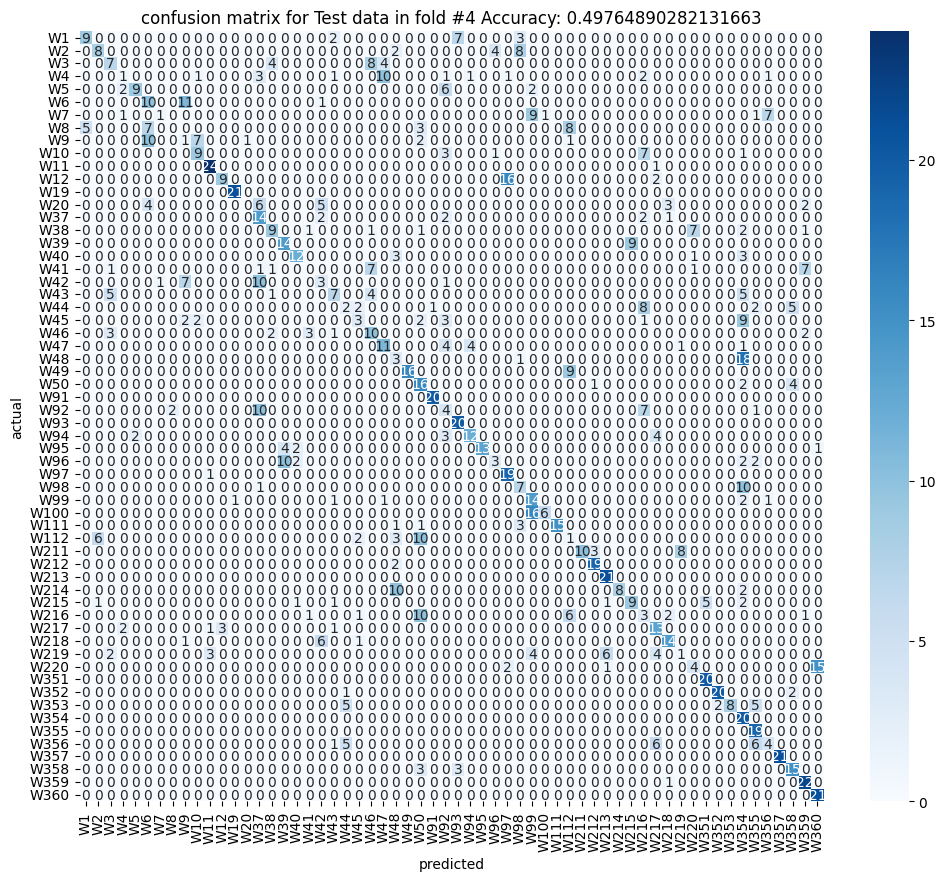

<Figure size 640x480 with 0 Axes>

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

conf_mat= conf_matrixes[bestTest-1]
print('test accuracies: ',test_accuracies, 'best:', bestTest-1)
# print ('validation accuracies: ',all_accuracies)
# average_conf_mat = np.mean(conf_matrixes, axis=0)
# for conf_matrix in conf_matrixes:
#     average_conf_mat +=  conf_matrix
# y_val_true_classes,y_val_pred_classes
ylabel =['W1','W2','W3','W4','W5','W6','W7','W8','W9','W10','W11','W12','W19','W20','W37','W38','W39','W40','W41','W42','W43','W44','W45','W46','W47','W48','W49','W50','W91','W92','W93','W94','W95','W96','W97','W98','W99','W100','W111','W112','W211','W212','W213','W214','W215','W216','W217','W218','W219','W220','W351','W352','W353','W354','W355','W356','W357','W358','W359','W360']
print(len(ylabel))
# ticklabels=np.unique(y_val_true_classes)
plt.figure(figsize=(12,10))
sns.heatmap(conf_mat, annot=True, fmt='d',cmap='Blues',xticklabels=ylabel,yticklabels=ylabel)
plt.title(f'confusion matrix for Test data in fold #{bestTest} Accuracy: {test_accuracies[bestTest-1]}')
plt.xlabel('predicted')
plt.ylabel('actual')
plt.show()

plt.savefig(f'HandPose_RightHand_LeftHandFlipped_acc_{bestTest-1}_{test_accuracies[bestTest-1]}.png')

In [14]:
# print(y_val_pred.shape)
# print(y_val_pred)
# print(y_val_pred[0][10])

# bestTest-1

plt.close

<function matplotlib.pyplot.close(fig=None)>

In [15]:
# y_val_pred = model.predict(x_val)
# print(y_val_pred[0])
# y_val_pred_classes = np.argmax(y_val_pred, axis=1)
# y_val_true_classes = np.argmax(y_val, axis=1)

In [16]:
print('Hello')

Hello
